*This notebook defines functions that are used to further preprocess and clean the brain scans. Firstly, the functions get rid of any artefacts that may be present in a scan -- this is done by setting the intensity value of those voxels to the threshold value. Secondly, we apply histogram matching to all the scans using a unique reference scan for the PETMR and TRIO datasets.*

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys

In [2]:
import nibabel as nib
import numpy as np
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

In [3]:
#this function simply uploads the selected scan

def get_data(subjects, petmr=False, trio=False):
    
    # Paths to the data scans
    petmr_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data'
    trio_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data'
    
    scans = []
    gtab = []
    
    if(petmr == True):
        print "Uploading PETMR scans:"
        data_path = petmr_data_path
    else:
        print "Uploading Trio scans:"
        data_path = trio_data_path
    os.chdir(data_path)
    for subj_scan in subjects:
        print "Subj%s" % (subj_scan)
        scan_image = nib.load(str(data_path) + "/Subj" + subj_scan + "/Brain_Extracted.nii.gz")
        scan_data = scan_image.get_data()
        #all scans have the same affine mat because registration has already been performed
        #we only need it for saving the predictions as a NIfTI file
        affine_mat = scan_image.affine
        bvals_scan, bvecs_scan = read_bvals_bvecs(str(data_path) + "/Subj" + subj_scan + "/NODDI.bval",\
                                                          str(data_path) + "/Subj" + subj_scan + "/NODDI.bvec")
        #set a threshold value for b=0 values (due to TRIO dataset)
        gtab_scan = gradient_table(bvals_scan, bvecs_scan, b0_threshold=5)
        scans.append(scan_data)
        gtab.append(gtab_scan)
    return (scans, gtab, affine_mat)

In [17]:
def analysis(scan, gtable, title, threshold):
    
    # Extract the b=0 volumes from the scan
    b_0s = scan[:,:,:,gtable.b0s_mask]
    
    mask = b_0s>0
    brain = b_0s[mask]
    
    
    print("maximum: %d" % brain.max())
    print("minimum: %d" % brain.min())
    print("average: %d" % brain.mean())
    print("median: %d" % np.median(brain))

    print("Total number of voxels: %d" % brain.shape[0])
    print("Voxels greater than threshold value (%d): %f" % (threshold, (brain>threshold).sum()))

    plt.hist(brain.flatten(), bins = 1024);
    plt.title(title)




In [22]:
def threshold(full_scan, gtable, threshold):

    # Apply the thresholding (replace values above threshold with the threshold value)
    full_scan[full_scan > threshold] = threshold
    
    return full_scan

In [6]:
# Paths to the data scans
petmr_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data'
trio_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data'

### Create PETMR referece scan
 
We identify a reference scan based on how *clean* the scan is -- it should contain minimal artefacts and should have a reasonable range with minimal high intensity voxels.
 
##### Use Subject 1 Scan 2 as the refernce scan

### Create TRIO referece scan
 
We identify a reference scan based on how *clean* the scan is -- it should contain minimal artefacts and should have a reasonable range with minimal high intensity voxels.
 
##### Use Subject 2 Scan 2 as the refernce scan

In [24]:
(trio_refernce_scan, gtable, affine_mat) = get_data(["1Scan1"], trio=True)

# Threshold the scan
trio_reference_scan_thresholded = threshold(scan[0], gtable[0], 1000)

# Store the thresholded scan
thresholded_scan_img = nib.Nifti1Image(trio_reference_scan_thresholded.astype(np.float32), affine_mat)
nib.save(thresholded_scan_img, str(trio_data_path)+ "/ReferenceScan/TRIO_REF.nii.gz" )

Uploading Trio scans:
Subj1Scan1


Uploading PETMR scans:
Subj1Scan1
maximum: 4095
minimum: 1
average: 398
median: 341
Total number of voxels: 818045
Voxels greater than threshold value (2400): 1261.000000


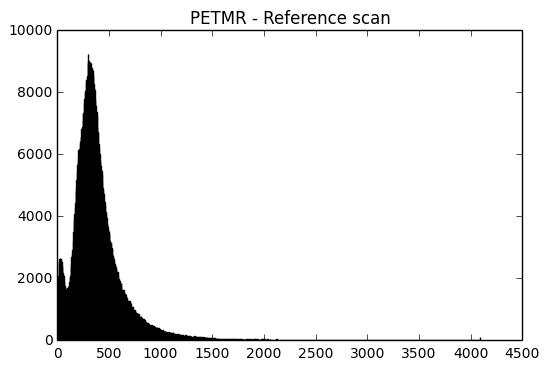

In [18]:
(petmr_refernce_scan, gtable, affine_mat) = get_data(["1Scan1"], petmr=True)

# plot a histogram using these b_0s volume use this to identify an appropriate threshold range
analysis(petmr_refernce_scan[0], gtable[0], "PETMR - Reference scan", 2400)

petmr_reference_scan_thresholded = threshold(scan[0], gtable[0], 2400)

# plot a histogram using these b_0s volume of the thresholded scan
analysis(thresholded_scan, gtable[0], "PETMR - Reference scan (Thresholded)", 2400)

# Store the thresholded scan
thresholded_scan_img = nib.Nifti1Image(thresholded_scan.astype(np.float32), affine_mat)
nib.save(thresholded_scan_img, str(petmr_data_path)+ "/Subj1Scan1/Brain_Extracted_Thresholded.nii.gz" )

#### Indentify the artifacts and get rid of them by replacing their intensity values with the threshold value, we use a threshold value of 2500

maximum: 2400
minimum: 1
average: 396
median: 341
Total number of voxels: 818045
Voxels greater than threshold value (2400): 0.000000


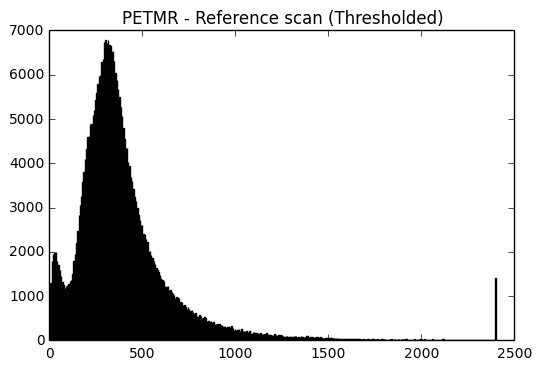

In [23]:
thresholded_scan = threshold(scan[0], gtable[0], 2400)

# plot a histogram using these b_0s volume of the thresholded scan
analysis(thresholded_scan, gtable[0], "PETMR - Reference scan (Thresholded)", 2400)

# Store the thresholded scan
thresholded_scan_img = nib.Nifti1Image(thresholded_scan.astype(np.float32), affine_mat)
nib.save(thresholded_scan_img, str(petmr_data_path)+ "/Subj1Scan1/Brain_Extracted_Thresholded.nii.gz" )